In [ ]:
import matplotlib.pyplot as plt
import torch
from muutils.dbg import dbg_auto

from spd.clustering.activations import component_activations, process_activations
from spd.clustering.merge import (
    MergeConfig,
    MergePlotConfig,
    merge_iteration_ensemble,
    plot_dists_distribution,
)
from spd.experiments.resid_mlp.resid_mlp_dataset import ResidualMLPDataset
from spd.models.component_model import ComponentModel
from spd.registry import CANONICAL_RUNS
from spd.utils.data_utils import DatasetGeneratedDataLoader

DEVICE: str = "cuda" if torch.cuda.is_available() else "cpu"

# magic autoreload
%load_ext autoreload
%autoreload 2

In [2]:
component_model, cfg, path = ComponentModel.from_pretrained(CANONICAL_RUNS["resid_mlp1"])
component_model.to(DEVICE);

Downloaded checkpoint from /home/miv/projects/MATS/spd/wandb/5mk5h1lk/files/resid_mlp.pth


In [3]:
N_SAMPLES: int = 512

dataset = ResidualMLPDataset(
    n_features=component_model.patched_model.config.n_features,
    feature_probability=cfg.task_config.feature_probability,
    device=DEVICE,
    calc_labels=False,  # Our labels will be the output of the target model
    label_type=None,
    act_fn_name=None,
    label_fn_seed=None,
    label_coeffs=None,
    data_generation_type=cfg.task_config.data_generation_type,
    # synced_inputs=synced_inputs,
)

dbg_auto(
    dict(
        n_features=dataset.n_features,
        feature_probability=dataset.feature_probability,
        data_generation_type=dataset.data_generation_type,
    )
)

dataloader = DatasetGeneratedDataLoader(dataset, batch_size=N_SAMPLES, shuffle=False)

[ /home/miv/projects/MATS/spd/.venv/lib/python3.13/site-packages/muutils/dbg.py:338 ] 
: <dict of len()=3, key_types={str}, val_types={float, int, str}>
  n_features: 100
  feature_probability: 0.01
  data_generation_type: 'at_least_zero_active'


In [5]:
ci = component_activations(
    component_model,
    dataloader,
    device=DEVICE,
    # threshold=0.1,
    # TODO: where can we find this in the model itself???
    sigmoid_type="hard",
)

dbg_auto(ci);

[ /home/miv/projects/MATS/spd/.venv/lib/python3.13/site-packages/muutils/dbg.py:338 ] 
: <dict of len()=2, key_types={str}, val_types={Tensor}>
  layers.0.mlp_in: μ=0.01 σ=0.09 x̃=0.00 R=[0.00,1.00] ℙ˪=|█▂▂▂▂▃▄| shape=(512,100) dtype=torch.float32 device=cuda:0 ∇✗
  layers.0.mlp_out: μ=0.05 σ=0.18 x̃=0.00 R=[0.00,0.97] ℙ˪=|█▅▅▅▅▅▅| shape=(512,100) dtype=torch.float32 device=cuda:0 ∇✗


[ activations.py:295 ] total_c = 200
[ activations.py:315 ] (len(dead_components_lst), len(labels)) = (50, 150)
[ /home/miv/projects/MATS/spd/.venv/lib/python3.13/site-packages/muutils/dbg.py:338 ] 
: <dict of len()=7, key_types={str}, val_types={Tensor, int, list}>
  activations: μ=0.04 σ=0.17 x̃=0.00 R=[0.00,1.00] ℙ˪=|█▅▅▅▄▅▅| shape=(512,150) dtype=torch.float32 device=cuda:0 ∇✗
  labels: <list of len()=150, types={str}>
  coactivations: μ=2.06 σ=4.68 x̃=0.10 R=[0.00,47.86] ℙ˪=|█▆▆▃▂▃▂| shape=(150,150) dtype=torch.float32 device=cuda:0 ∇✗
  dead_components_lst: <list of len()=50, types={str}>
  n_components_original: 200
  n_components_alive: 150
  n_components_dead: 50


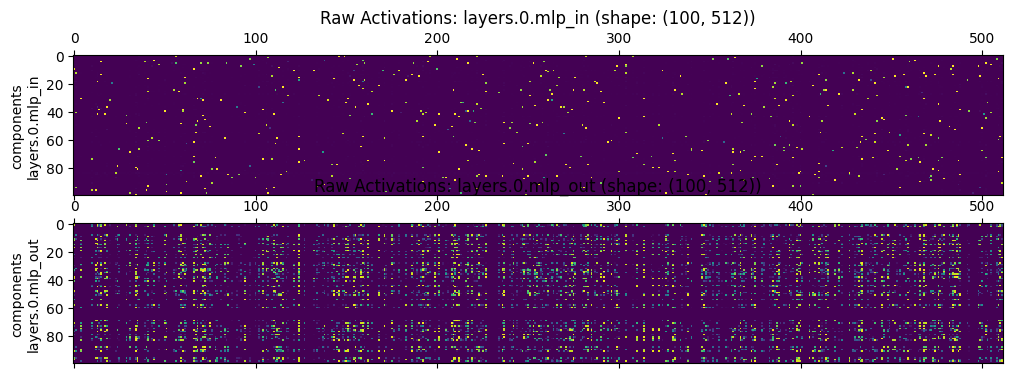

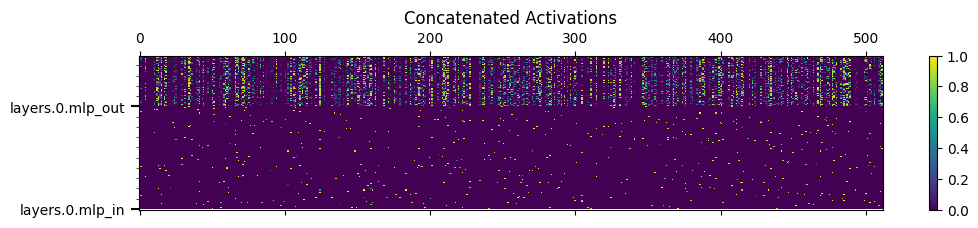

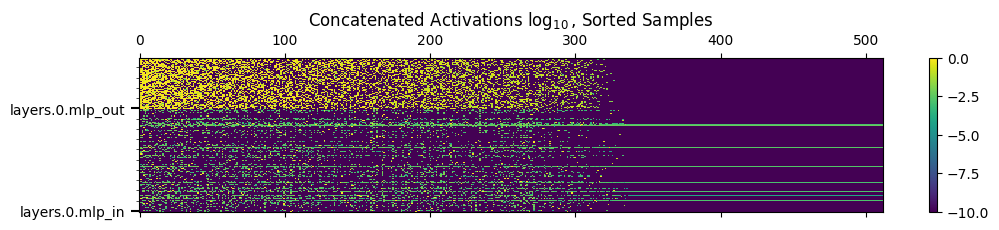

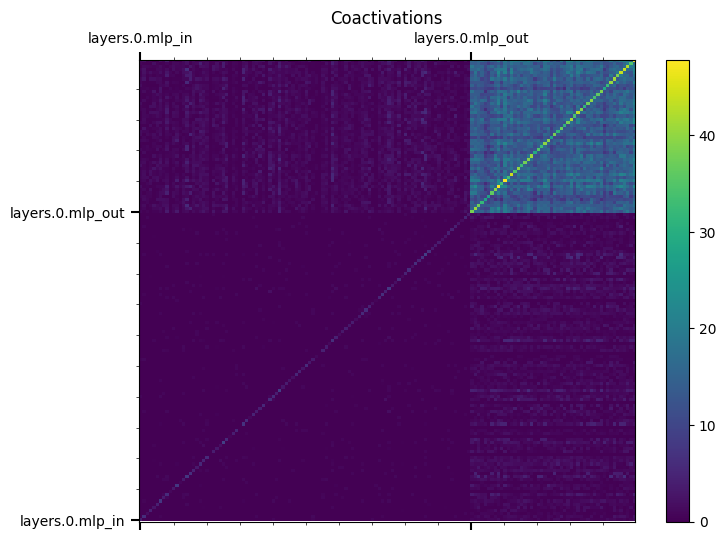

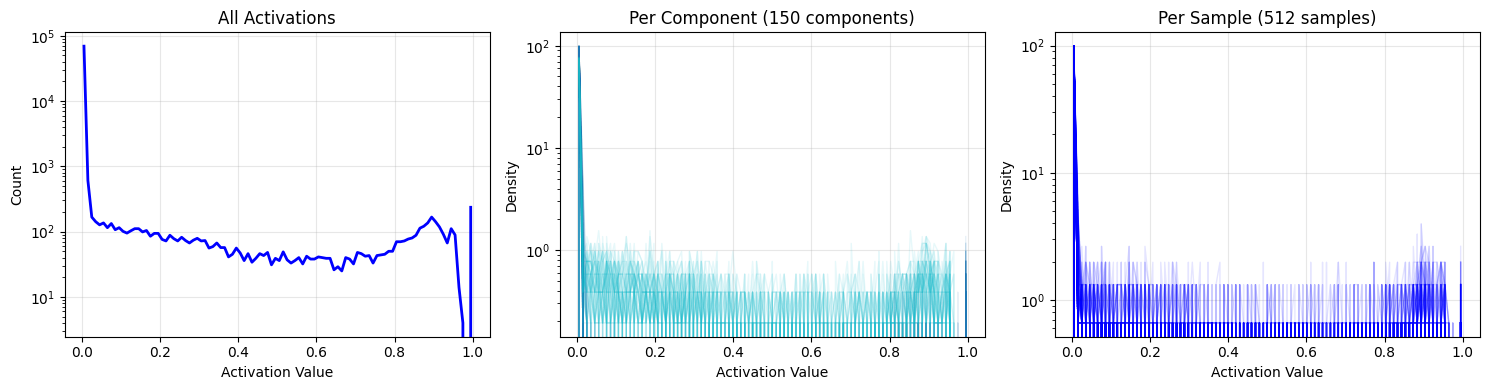

In [6]:
coa = process_activations(
    ci,
    filter_dead_threshold=0.001,
    plots=True,  # Plot the processed activations
    # plot_title="Processed Activations",
);

$$
	F_g := \frac{\alpha}{n}
	\Bigg[
		d(A(g)) \cdot Q^T 
		+ Q \cdot d(A(g))^T
		- \Big(
			R \mathbf{1}^T
			+ \mathbf{1} R^T + \alpha^{-1}
		\Big) 
		\odot A(g)
	\Bigg]
$$

/tmp/ipykernel_772152/1342956652.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


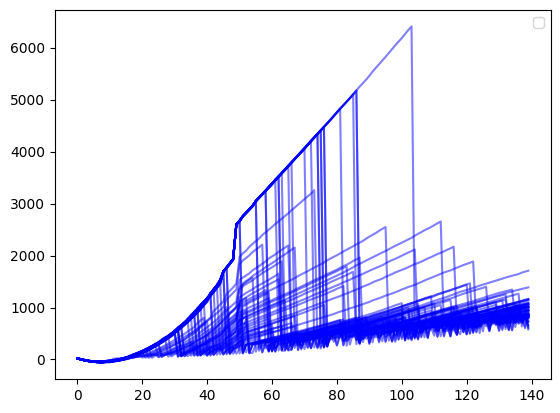

In [ ]:


from spd.clustering.merge import MergeEnsemble

ENSEMBLE: MergeEnsemble = merge_iteration_ensemble(
    activations=coa["activations"],
    component_labels=coa["labels"],
    merge_config=MergeConfig(
        activation_threshold=None,
        alpha=0.01,
        iters=140,
        check_threshold=0.1,
        pop_component_prob=0.1,
        rank_cost_fn=lambda x: 1.0,
        stopping_condition=None,
    ),
    plot_config=MergePlotConfig(
        plot_every=999,
        plot_every_min=999,
		# plot_every=5,
        save_pdf=False,
        # pdf_prefix="merge_iteration",
        figsize=(16, 3),
        figsize_final=(10, 6),
        tick_spacing=10,
        plot_final=False,
    ),
	ensemble_size=64,
)

In [ ]:
for x in ENSEMBLE:
    plt.plot(x.non_diag_costs_min, "b-", alpha=0.5)
plt.legend()

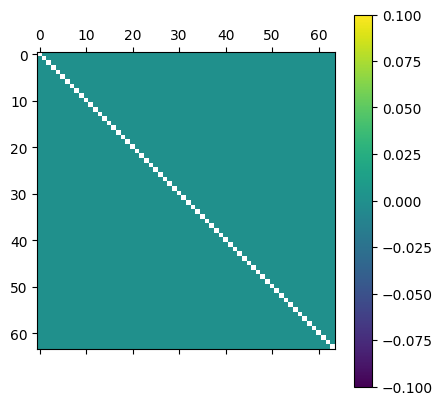

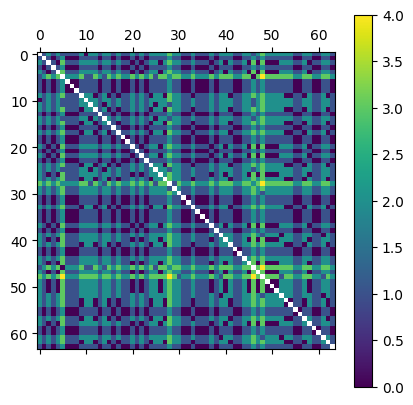

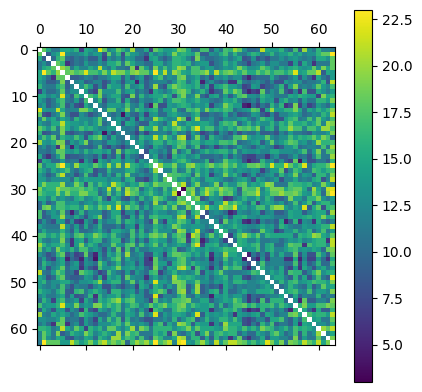

In [ ]:
DISTANCES = ENSEMBLE.get_distances()


In [ ]:

for i in range(ENSEMBLE.n_iters):
	if i % 50 == 0:
		plt.matshow(DISTANCES[i], cmap="viridis")
		plt.colorbar()


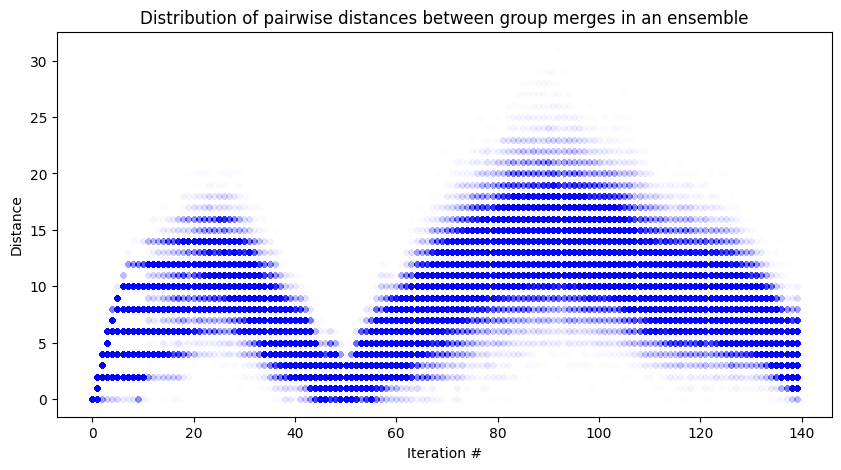

In [ ]:
plot_dists_distribution(
	distances=DISTANCES,
)